---
* *** 원본 소스는 홍콩과기대 김성훈 교수님의  [Github link](https://github.com/hunkim/DeepLearningZeroToAll)를 참조하세요 ***     
* *** Watson studio notebook 에서 작업 가능하도록 수정하였으며***
* *** 한글로 설명된 부분은 제가 스터디 하면서 이해한 내용을 추가한 것입니다. ***
---

## MNIST data를 가지고 2개의 CNN과 1개의 FC로 처리해보기 

In [1]:
# Lab 11 MNIST and Convolutional Neural Network
import tensorflow as tf
import random
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data

tf.set_random_seed(777)  # reproducibility

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
# Check out https://www.tensorflow.org/get_started/mnist/beginners for
# more information about the mnist dataset

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
!dir MNIST_data

t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


* ***  cnn --> relu --> max_pool 처리 Layer를 2번 수행 ***

In [3]:
# input place holders
X = tf.placeholder(tf.float32, [None, 784])   # 전체 image 처리 갯수
X_img = tf.reshape(X, [-1, 28, 28, 1])   # img 28x28x1 (black/white)
Y = tf.placeholder(tf.float32, [None, 10])     # lable 갯수

# L1 ImgIn shape=(?, 28, 28, 1)
W1 = tf.Variable(tf.random_normal([3, 3, 1, 32], stddev=0.01))    # 32개 filter 사용
#    Conv     -> (?, 28, 28, 32)
#    Pool     -> (?, 14, 14, 32)
L1 = tf.nn.conv2d(X_img, W1, strides=[1, 1, 1, 1], padding='SAME')
print(L1)
L1 = tf.nn.relu(L1)
print(L1)
L1 = tf.nn.max_pool(L1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
print(L1)
'''
Tensor("Conv2D:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("Relu:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)
'''

Tensor("Conv2D:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("Relu:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)


'\nTensor("Conv2D:0", shape=(?, 28, 28, 32), dtype=float32)\nTensor("Relu:0", shape=(?, 28, 28, 32), dtype=float32)\nTensor("MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)\n'

In [4]:
# L2 ImgIn shape=(?, 14, 14, 32)
W2 = tf.Variable(tf.random_normal([3, 3, 32, 64], stddev=0.01))   # 64개 filter 사용
#    Conv      ->(?, 14, 14, 64)
#    Pool      ->(?, 7, 7, 64)
L2 = tf.nn.conv2d(L1, W2, strides=[1, 1, 1, 1], padding='SAME')
print(L2)
L2 = tf.nn.relu(L2)
print(L2)
L2 = tf.nn.max_pool(L2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
print(L2)
L2_flat = tf.reshape(L2, [-1, 7 * 7 * 64])   # full connected 로 넣기 위해서 1차원으로 만들어줌

'''
Tensor("Conv2D_1:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("Relu_1:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("MaxPool_1:0", shape=(?, 7, 7, 64), dtype=float32)
Tensor("Reshape_1:0", shape=(?, 3136), dtype=float32)
'''

Tensor("Conv2D_1:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("Relu_1:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("MaxPool_1:0", shape=(?, 7, 7, 64), dtype=float32)


'\nTensor("Conv2D_1:0", shape=(?, 14, 14, 64), dtype=float32)\nTensor("Relu_1:0", shape=(?, 14, 14, 64), dtype=float32)\nTensor("MaxPool_1:0", shape=(?, 7, 7, 64), dtype=float32)\nTensor("Reshape_1:0", shape=(?, 3136), dtype=float32)\n'

* ***CNN 처리 이후에 learning 수행***

In [5]:
# Final FC 7x7x64 inputs -> 10 outputs

# hyper parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100

W3 = tf.get_variable("W3", shape=[7 * 7 * 64, 10],
                     initializer=tf.contrib.layers.xavier_initializer())
b = tf.Variable(tf.random_normal([10]))
logits = tf.matmul(L2_flat, W3) + b

# define cost/loss & optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [6]:
# initialize
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# train my model
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(mnist.train.num_examples / batch_size)

    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        feed_dict = {X: batch_xs, Y: batch_ys}
        c, _ = sess.run([cost, optimizer], feed_dict=feed_dict)
        avg_cost += c / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning Finished!')

Learning started. It takes sometime.
Epoch: 0001 cost = 0.345597459
Epoch: 0002 cost = 0.091797432
Epoch: 0003 cost = 0.068372396
Epoch: 0004 cost = 0.056379004
Epoch: 0005 cost = 0.046920019
Epoch: 0006 cost = 0.041171568
Epoch: 0007 cost = 0.036644606
Epoch: 0008 cost = 0.032853815
Epoch: 0009 cost = 0.028126524
Epoch: 0010 cost = 0.024791351
Epoch: 0011 cost = 0.022118081
Epoch: 0012 cost = 0.020218051
Epoch: 0013 cost = 0.017048809
Epoch: 0015 cost = 0.013110995
Learning Finished!


In [7]:
# Test model and check accuracy
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print('Accuracy:', sess.run(accuracy, feed_dict={
      X: mnist.test.images, Y: mnist.test.labels}))

Accuracy: 0.9879


Label:  [4]
Prediction:  [4]


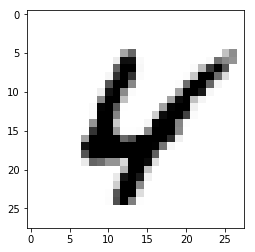

In [8]:
# Get one and predict
r = random.randint(0, mnist.test.num_examples - 1)
print("Label: ", sess.run(tf.argmax(mnist.test.labels[r:r + 1], 1)))
print("Prediction: ", sess.run(
    tf.argmax(logits, 1), feed_dict={X: mnist.test.images[r:r + 1]}))

plt.imshow(mnist.test.images[r:r + 1].
           reshape(28, 28), cmap='Greys', interpolation='nearest')
plt.show()

In [9]:
'''
Epoch: 0001 cost = 0.340291267
Epoch: 0002 cost = 0.090731326
Epoch: 0003 cost = 0.064477619
Epoch: 0004 cost = 0.050683064
Epoch: 0005 cost = 0.041864835
Epoch: 0006 cost = 0.035760704
Epoch: 0007 cost = 0.030572132
Epoch: 0008 cost = 0.026207981
Epoch: 0009 cost = 0.022622454
Epoch: 0010 cost = 0.019055919
Epoch: 0011 cost = 0.017758641
Epoch: 0012 cost = 0.014156652
Epoch: 0013 cost = 0.012397016
Epoch: 0014 cost = 0.010693789
Epoch: 0015 cost = 0.009469977
Learning Finished!
Accuracy: 0.9885
'''

'\nEpoch: 0001 cost = 0.340291267\nEpoch: 0002 cost = 0.090731326\nEpoch: 0003 cost = 0.064477619\nEpoch: 0004 cost = 0.050683064\nEpoch: 0005 cost = 0.041864835\nEpoch: 0006 cost = 0.035760704\nEpoch: 0007 cost = 0.030572132\nEpoch: 0008 cost = 0.026207981\nEpoch: 0009 cost = 0.022622454\nEpoch: 0010 cost = 0.019055919\nEpoch: 0011 cost = 0.017758641\nEpoch: 0012 cost = 0.014156652\nEpoch: 0013 cost = 0.012397016\nEpoch: 0014 cost = 0.010693789\nEpoch: 0015 cost = 0.009469977\nLearning Finished!\nAccuracy: 0.9885\n'